In [ ]:
import shutil
from pathlib import Path

# This will clear the entire Hugging Face cache directory
cache_dir = Path.home() / ".cache" / "huggingface"

# Clear entire cache — USE WITH CAUTION
shutil.rmtree(cache_dir, ignore_errors=True)
print(f"Cleared Hugging Face cache at {cache_dir}")


In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from transformers import CLIPTokenizer
from datasets import load_dataset, concatenate_datasets, Image, Value, Features
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, AutoencoderKL, UNet2DConditionModel, DDPMScheduler

from peft import LoraConfig, get_peft_model
from torchvision import transforms
import requests
import random

from diffusers import StableDiffusionPipeline
import time
from peft import PeftModel
from IPython.display import display

2025-04-16 18:24:19.645730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744827859.949664      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744827860.029632      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# ----------------------------
# 1. CONFIGURATION
# ----------------------------
MODEL_NAME = "stabilityai/sd-turbo"  # Using SD-Turbo for faster inference
BATCH_SIZE = 2  # Keep it small for CPU
IMAGE_SIZE = 256
MAX_PROMPT_LENGTH = 77
EPOCHS = 5
VALIDATION_SPLIT = 0.1  # 10% of data used for validation

print("✅ Configuration loaded.")

In [ ]:
# ----------------------------
# 2. DATA PREPROCESSING CLASS
# ----------------------------
class FashionDataset(Dataset):
    def __init__(self, hf_datasets, tokenizer, transform):
        self.dataset = hf_datasets
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        prompt = item["prompt"]

        # Encode prompt text
        input_ids = self.tokenizer(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=MAX_PROMPT_LENGTH,
            return_tensors="pt"
        ).input_ids.squeeze(0)

        # Convert and normalize image
        pixel_values = self.transform(image)

        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
        }


In [ ]:
# ----------------------------
# 3. LOAD & COMBINE DATASETS
# ----------------------------
def combine_fashion_datasets():
    print("🔄 Loading and preprocessing datasets...")

    def map_ceyda(example):
        example["prompt"] = f"{example.get('gender', '')} {example.get('subCategory', '')}".strip()
        return example

    print("Loading Dataset 1...")
    ds1 = load_dataset("Abrumu/Fashion_controlnet_dataset_V3", split="train[:5200]")
    ds1 = ds1.remove_columns(["prompt"]) 
    ds1 = ds1.rename_columns({"target": "image", "CLIP_captions": "prompt"})

    print("Loading Dataset 2...")
    ds2 = load_dataset("ceyda/fashion-products-small", split="train[:5500]").map(map_ceyda).remove_columns(["gender", "subCategory"])

    print("Loading Dataset 3 ...")
    ds3 = load_dataset("tomytjandra/h-and-m-fashion-caption", split="train[:5700]").rename_columns({"text": "prompt"})

    # Strip other columns
    ds1 = ds1.remove_columns([col for col in ds1.column_names if col not in ["image", "prompt"]])
    ds2 = ds2.remove_columns([col for col in ds2.column_names if col not in ["image", "prompt"]])
    ds3 = ds3.remove_columns([col for col in ds3.column_names if col not in ["image", "prompt"]])

    # Force common schema
    unified_features = Features({
        "image": Image(),
        "prompt": Value("string")
    })

    ds1 = ds1.cast(unified_features)
    ds2 = ds2.cast(unified_features)
    ds3 = ds3.cast(unified_features)

    print("Combining all datasets...")
    combined = concatenate_datasets([ds1, ds2, ds3])

    return combined

In [ ]:
# ----------------------------
# 4. IMAGE TRANSFORM
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
print("✅ Ready.")

In [ ]:
# ----------------------------
# 5. LOAD BASE MODEL + LORA
# ----------------------------

from accelerate import Accelerator

print("🚀 Initializing Accelerator...")
accelerator = Accelerator(mixed_precision="fp16")  # mixed precision for speed/memory
device = accelerator.device

print("📦 Loading base components from SD-Turbo...")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Load the text encoder directly (since you’re not using the full pipeline anymore)
from transformers import CLIPTextModel
# text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")

# LoRA setup
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["attn1.to_q", "attn1.to_k", "attn1.to_v"],
    lora_dropout=0.1,
    bias="none"
)
unet = get_peft_model(unet, lora_config)

print("✅ Models (UNet, VAE, TextEncoder, Tokenizer) ready.")



In [ ]:
# Check which parameters are trainable
def print_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"🧠 Trainable parameters: {trainable}")
    print(f"🔢 Total parameters: {total}")
    print(f"🎯 Trainable ratio: {100 * trainable / total:.4f}%")

print_trainable_params(unet)

In [ ]:
# # Optional: Verify if LoRA layers are being trained
# for name, param in unet.named_parameters():
#     if param.requires_grad:
#         print(f"✅ Trainable: {name}")


In [ ]:
# ----------------------------
# 6. LOAD DATA INTO DATALOADER
# ----------------------------
print("📥 Preparing dataset...")
combined_dataset = combine_fashion_datasets()

# Split into train and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_dataset = FashionDataset(train_dataset, tokenizer, transform)
val_dataset = FashionDataset(val_dataset, tokenizer, transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"📝 Training dataset size: {len(train_dataset)}")
print(f"📝 Validation dataset size: {len(val_dataset)}")


In [ ]:
# ----------------------------
# 7. TRAINING LOOP
# ----------------------------

print("🚦 Preparing training loop with Accelerator...")

scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
optimizer = torch.optim.AdamW(unet.parameters(), lr=5e-5)

# make all of it ready to run on the right device (GPU/CPU) and supports multi-GPU if needed
unet, vae, text_encoder, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    unet, vae, text_encoder, optimizer, train_dataloader, val_dataloader
)

print("🚀 Starting training loop...")

for epoch in range(EPOCHS):
    print(f"\n🔁 Epoch {epoch + 1}/{EPOCHS}")
    unet.train()
    total_loss = 0.0

    for step, batch in enumerate(train_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        with torch.no_grad():
            # image goes into the VAE, which compresses it into latent vectors
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215 # scaling factor (used in Stable Diffusion by default)
            # Add random noise to the latents at a random timestep
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), dtype=torch.long).to(device)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(input_ids)[0]  
        # Forward UNet
        # The UNet tries to predict the noise that was added earlier.
        # This is how the model learns to “denoise” and reconstruct the image step by step.
        model_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=encoder_hidden_states
        ).sample

        loss = torch.nn.functional.mse_loss(model_pred, noise)# Compare the predicted noise with the actual noise using Mean Squared Error (MSE).

        # Backpropagate the loss and update the model weights.
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()

        total_loss += loss.item()
        if step % 10 == 0:
            print(f"🧮 Epoch {epoch+1} | Step {step}/{len(train_dataloader)} | Loss: {loss.item():.4f}")

    print(f"📉 Epoch {epoch+1} Training Loss: {total_loss/len(train_dataloader):.4f}")

    # ---- Validation ----
    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)

            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), dtype=torch.long).to(device)
            noisy_latents = scheduler.add_noise(latents, noise, timesteps)
            encoder_hidden_states = text_encoder(input_ids)[0]

            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=encoder_hidden_states
            ).sample

            loss = torch.nn.functional.mse_loss(model_pred, noise)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"✅ [Validation] Epoch {epoch + 1} | Validation Loss: {avg_val_loss:.4f}")

print("✅ Training complete.")

In [ ]:
# ----------------------------
# 8. SAVE FINE-TUNED MODEL
# ----------------------------
print("💾 Saving LoRA fine-tuned UNet...")
accelerator.wait_for_everyone()
unet = accelerator.unwrap_model(unet)
unet.save_pretrained("/kaggle/working/fashion-lora-sd-turbo-unet-data2x-epoch5")
print("✅ UNet saved to 'fashion-lora-sd-turbo-unet'")


In [4]:
def print_model_details(model, title="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n🧠 {title} Details:")
    print(f"🔢 Total parameters: {total_params:,}")
    print(f"📝 Trainable parameters: {trainable_params:,}")
    print(f"🎯 Trainable ratio: {100 * trainable_params / total_params:.4f}%\n")


🔧 Loading SD-Turbo base pipeline with LoRA...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ LoRA fine-tuned model loaded.
🖼️ Generating image with LoRA fine-tuned model...


  0%|          | 0/25 [00:00<?, ?it/s]

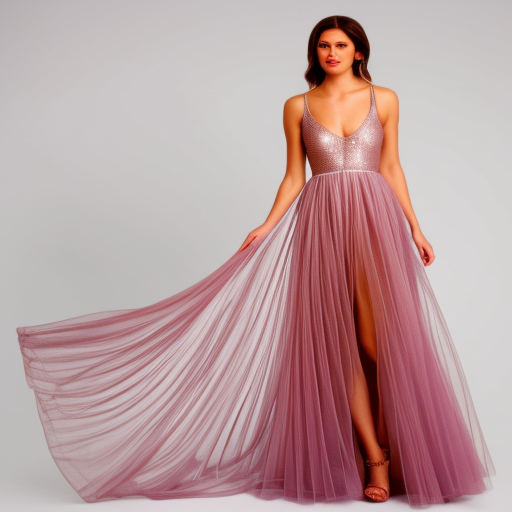

⏱️ Total pipeline + inference time (LoRA): 6.29 sec
⚡ Inference time only (LoRA): 3.88 sec

🧠 UNet (LoRA Fine-Tuned) Details:
🔢 Total parameters: 866,509,764
📝 Trainable parameters: 0
🎯 Trainable ratio: 0.0000%



In [10]:
# 🔧 Fine-tuned LoRA Model Inference (with timing)

# Load the base pipeline
print("🔧 Loading SD-Turbo base pipeline with LoRA...")
start_time = time.time()

pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/sd-turbo",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Load LoRA fine-tuned UNet
pipe.unet = PeftModel.from_pretrained(pipe.unet, "/kaggle/working/fashion-lora-sd-turbo-unet-data2x-epoch5")
print("✅ LoRA fine-tuned model loaded.")

# Prompt
prompt = "a unique shimmering with pink hem mesh gown"

# Inference
print("🖼️ Generating image with LoRA fine-tuned model...")
inference_start = time.time()
with torch.autocast("cuda"):
    image = pipe(prompt=prompt, num_inference_steps=25).images[0]
inference_end = time.time()

# Save and display
image.save("generated_fashion_lora.png")
display(image)

# Timing
total_time = time.time() - start_time
inference_time = inference_end - inference_start
print(f"⏱️ Total pipeline + inference time (LoRA): {total_time:.2f} sec")
print(f"⚡ Inference time only (LoRA): {inference_time:.2f} sec")

print_model_details(pipe.unet, "UNet (LoRA Fine-Tuned)")


📦 Loading original SD-Turbo pipeline...


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Original model loaded.
🖼️ Generating image with original model...


  0%|          | 0/25 [00:00<?, ?it/s]

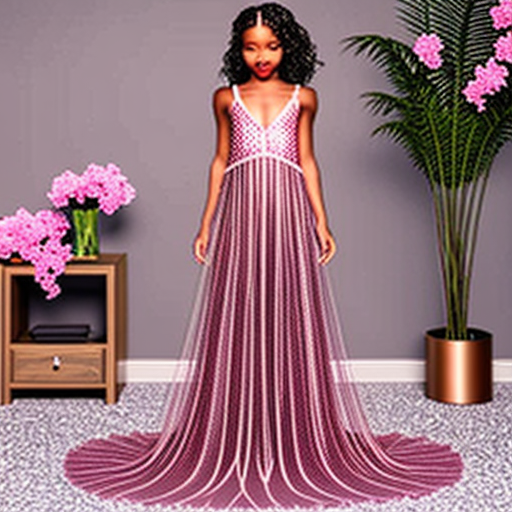

⏱️ Total pipeline + inference time (Original): 6.13 sec
⚡ Inference time only (Original): 3.76 sec

🧠 Original UNet Details:
🔢 Total parameters: 865,910,724
📝 Trainable parameters: 865,910,724
🎯 Trainable ratio: 100.0000%



In [11]:
# 🧪 Original SD-Turbo Model Inference (no LoRA)

# Load base SD-Turbo
print("📦 Loading original SD-Turbo pipeline...")
start_time = time.time()

pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/sd-turbo",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

print("✅ Original model loaded.")

# Prompt
prompt = "a unique shimmering with pink hem mesh gown"

# Inference
print("🖼️ Generating image with original model...")
inference_start = time.time()
with torch.autocast("cuda"):
    image = pipe(prompt=prompt, num_inference_steps=25).images[0]
inference_end = time.time()

# Save and display
image.save("generated_fashion_original.png")
display(image)

# Timing
total_time = time.time() - start_time
inference_time = inference_end - inference_start
print(f"⏱️ Total pipeline + inference time (Original): {total_time:.2f} sec")
print(f"⚡ Inference time only (Original): {inference_time:.2f} sec")

print_model_details(pipe.unet, "Original UNet")
